In [2]:
import matplotlib.pyplot as plt
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Flatten
from keras import backend as K
import numpy as np 
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics 
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline           

In [3]:
# create the base pre-trained model
# build the VGG16 network
base_model = applications.xception.Xception(weights='imagenet', include_top=False, 
                                input_shape=(150,150,3))
print('Model loaded.')
base_model.summary()

W0213 16:30:31.749927 140234545289024 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0213 16:30:31.761652 140234545289024 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0213 16:30:31.763499 140234545289024 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0213 16:30:31.778156 140234545289024 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session in

83689472/83683744 [==============================] - 1s 0us/step
Model loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________

In [4]:
# this is the model we will train
model =Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 33,969,193
Trainable params: 33,914,665
Non-trainable params: 54,528
_________________________________________________________________


In [5]:
print('Number of trainable weights before freezing: ', len(model.trainable_weights))
## to freesze all convolutional layers in pretrained network method 1
# base_model.trainable=False

Number of trainable weights before freezing:  158


In [6]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
#     possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall
# def precision_m(y_true, ypred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
#     precision = true_positives/(predicted_positives+K.epsilon())
#     return precision 

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional pretrained layers method 2
for layer in base_model.layers:
    layer.trainable = False
print('After freezing: ', len(model.trainable_weights))
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'], loss='binary_crossentropy')


W0213 16:30:39.503190 140234545289024 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0213 16:30:39.509083 140234545289024 deprecation.py:323] From /home/mlab/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


After freezing:  4


In [7]:
train_data_dir = '/home/mlab/Documents/brats_hl_data/train'
validation_data_dir = '/home/mlab/Documents/brats_hl_data/val'
# 44938
# 5616
nb_train_samples = 44938
nb_validation_samples = 5616
epochs = 8
batch_size = 128
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

Found 44938 images belonging to 2 classes.
Found 5616 images belonging to 2 classes.


In [8]:
true_classes = train_generator.classes
print(true_classes)
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

[0 0 0 ... 1 1 1]
['high', 'low']


In [9]:
# train the model on the new data for a few epochs
history =model.fit_generator(train_generator,
                             steps_per_epoch=nb_train_samples//batch_size,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=nb_validation_samples//batch_size)

Epoch 1/8
351/351 [==============================] - 1145s 3s/step - loss: 0.5926 - acc: 0.6712 - val_loss: 0.5249 - val_acc: 0.7304
Epoch 2/8
351/351 [==============================] - 1128s 3s/step - loss: 0.5260 - acc: 0.7218 - val_loss: 0.5015 - val_acc: 0.7365
Epoch 3/8
351/351 [==============================] - 1128s 3s/step - loss: 0.4937 - acc: 0.7442 - val_loss: 0.4839 - val_acc: 0.7502
Epoch 4/8
351/351 [==============================] - 1127s 3s/step - loss: 0.4700 - acc: 0.7607 - val_loss: 0.4751 - val_acc: 0.7613
Epoch 5/8
351/351 [==============================] - 1125s 3s/step - loss: 0.4546 - acc: 0.7737 - val_loss: 0.4471 - val_acc: 0.7735
Epoch 6/8
351/351 [==============================] - 1125s 3s/step - loss: 0.4388 - acc: 0.7805 - val_loss: 0.4476 - val_acc: 0.7761
Epoch 7/8
351/351 [==============================] - 1124s 3s/step - loss: 0.4214 - acc: 0.7913 - val_loss: 0.4410 - val_acc: 0.7793
Epoch 8/8
351/351 [==============================] - 1126s 3s/step - 

In [10]:
true_classes_1 = validation_generator.classes
print(true_classes)
class_labels_1 = list(validation_generator.class_indices.keys())
print(class_labels_1)

[0 0 0 ... 1 1 1]
['high', 'low']


In [11]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)


In [12]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = (Y_pred<0.475).astype(np.int)

# print('Confusion Matrix')
# print(confusion_matrix(true_classes_1, y_pred))
# print('Classification Report')
# print(classification_report(validation_generator.classes, y_pred, 
#                             target_names=class_labels_1))


In [13]:
# print(validation_generator.classes)

In [14]:
confusion_matrix = metrics.confusion_matrix(true_classes_1,y_pred)
print(confusion_matrix)

[[1244 1531]
 [1244 1597]]


In [15]:
report= sklearn.metrics.classification_report(true_classes_1, y_pred, 
                                              target_names = class_labels_1)
print(report)

              precision    recall  f1-score   support

        high       0.50      0.45      0.47      2775
         low       0.51      0.56      0.54      2841

   micro avg       0.51      0.51      0.51      5616
   macro avg       0.51      0.51      0.50      5616
weighted avg       0.51      0.51      0.50      5616



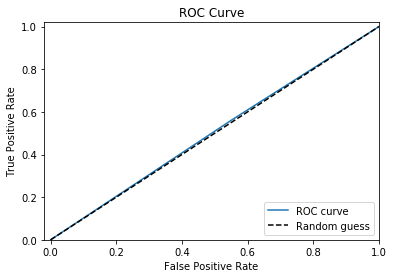

In [16]:
fpr, tpr, thresholds = roc_curve(validation_generator.classes, y_pred)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [17]:
roc_auc_score(validation_generator.classes, y_pred)

0.5052071501279527

In [18]:
batchX, batchy = train_generator.next()
_, accuracy = model.evaluate(batchX, batchy)
print('Accuracy training: %.2f' % (accuracy*100))
batchXv, batchyv = validation_generator.next()
_, accuracy = model.evaluate(batchXv, batchyv)
print('Accuracy val: %.2f' % (accuracy*100))

128/128 [==============================] - 3s 23ms/step
Accuracy training: 84.38
128/128 [==============================] - 3s 23ms/step
Accuracy val: 78.12


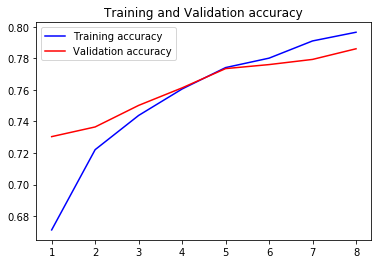

In [19]:
#plot the train and val curve
#get the details from the history object
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

#train and validation accuracy
plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

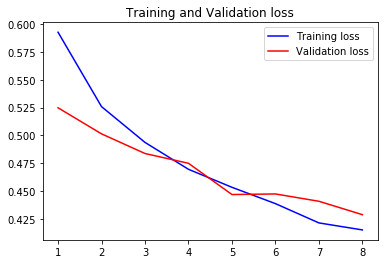

In [20]:
#train and validation loss
plt.plot(epochs, loss, 'b',label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [21]:
test_generator = test_datagen.flow_from_directory('/home/mlab/Documents/brats_hl_data/test', 
                                      class_mode='binary', 
                                      batch_size=batch_size, 
                                      target_size=(150,150))
scores = model.evaluate_generator(test_generator, steps=nb_validation_samples//batch_size)

Found 5619 images belonging to 2 classes.


In [22]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 77.76%


In [23]:
#Confution Matrix and Classification Report
# Y_pred = model.predict_generator(val_generator, 5616 // batch_size)
nb_test_samples=5619
Y_pred1 = model.predict_generator(test_generator,nb_test_samples//batch_size+1)
# y_pred = np.argmax(Y_pred,axis=1)

In [24]:
true_classes_2 = test_generator.classes
print(true_classes_2)
class_labels_2 = list(test_generator.class_indices.keys())
print(class_labels_2)

[0 0 0 ... 1 1 1]
['high', 'low']


In [25]:
# y_pred1 = (Y_pred1<0.5).astype(np.int)
y_pred1 = (Y_pred1 < 0.475).astype(np.int)
# print(y_pred)
# print('Confusion Matrix')
# print(confusion_matrix(true_classes_2, y_pred1))
# print('Classification Report')
# print(classification_report(true_classes_2, y_pred1, target_names=class_labels_2))


In [26]:
confusion_matrix1 = metrics.confusion_matrix(true_classes_2,y_pred1)
print(confusion_matrix1)

[[1218 1558]
 [1294 1549]]


In [27]:
report1= sklearn.metrics.classification_report(true_classes_2, y_pred1, 
                                               target_names = class_labels_2)
print(report1)

              precision    recall  f1-score   support

        high       0.48      0.44      0.46      2776
         low       0.50      0.54      0.52      2843

   micro avg       0.49      0.49      0.49      5619
   macro avg       0.49      0.49      0.49      5619
weighted avg       0.49      0.49      0.49      5619



In [28]:
print(" Loss: ", scores[0],"\n","Accuracy: ", scores[1])

 Loss:  0.44377977972806887 
 Accuracy:  0.7776162790697675
